In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from glob import glob
from PIL import Image
from numpy import asarray

In [4]:
dirct = 'F:/Aman Programming/Brain Tumor Detection/Brain-Tumor-Detection-main'

In [5]:
import os
path = os.listdir(dirct + '/Brain_Tumor_Data')
classes = {'no_tumor':0, 'pituitary_tumor':1}

In [6]:
no_tumor_frompath= dirct+'/Brain_Tumor_Data/Training/no_tumor'
no_tumor_topath = dirct+'/Brain_Tumor_Data/Agumented_Data/Training/no_tumor/'
no_tumor_images=glob(no_tumor_frompath+'/*')
c=0
for path in no_tumor_images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1

In [7]:
frompath = dirct+'Brain_Tumor_Data/Training/pituitary_tumor'
topath = dirct+'Brain_Tumor_Data/Agumented_Data/Training/pituitary_tumor/'
images=glob(frompath+'/*')
c=0
for path in images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(topath+str(c)+'.jpg')
  c+=1

In [8]:
import cv2
X=[]
Y=[]
for cls in classes:
  pth = dirct+'/Brain_Tumor_Data/Agumented_Data/Training/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j)   
    # img = cv2.resize(img,dsize=(224,224))
    X.append(img)
    Y.append(classes[cls])

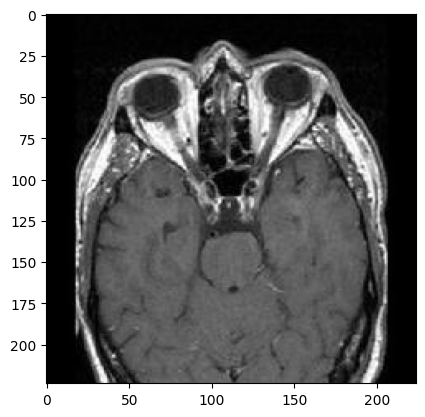

In [9]:
plt.imshow(X[0],cmap='gray')

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=10,test_size=0.20)
print ("Shape of an image in x_train: ", x_train[0].shape)
print ("Shape of an image in x_test: ", x_test[0].shape)

Shape of an image in x_train:  (224, 224, 3)
Shape of an image in x_test:  (224, 224, 3)


In [11]:
from sklearn import preprocessing
import tensorflow as tf
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test) 
print("x_train Shape: ", x_train.shape) 
print("x_test Shape: ", x_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

x_train Shape:  (3910, 224, 224, 3)
x_test Shape:  (978, 224, 224, 3)
y_train Shape:  (3910, 2)
y_test Shape:  (978, 2)


In [14]:
# import sys
# print(sys.executable)

from keras.applications import vgg16

img_rows,img_cols=224,224

vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [15]:
for layer in vgg.layers:
  layer.trainable=False


In [17]:
from keras.layers import GlobalAveragePooling2D, Dense

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [18]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.models import Model

In [19]:
import tempfile

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__


In [20]:
make_keras_picklable()

In [21]:
num_classes=2
FC_Head=lw(vgg,num_classes)
model=Model(inputs=vgg.input,outputs=FC_Head)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [23]:
from keras.models import Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),verbose=1,initial_epoch=0)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 689s 6s/step - accuracy: 0.8339 - loss: 1.3692 - val_accuracy: 0.9581 - val_loss: 0.1515
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.9738 - loss: 0.0768 - val_accuracy: 0.9816 - val_loss: 0.0589
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.9917 - loss: 0.0284 - val_accuracy: 0.9898 - val_loss: 0.0377
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.9972 - loss: 0.0077 - val_accuracy: 0.9918 - val_loss: 0.0417
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - accuracy: 0.9950 - loss: 0.0194 - val_accuracy: 0.9663 - val_loss: 0.1451


In [25]:
import pickle
filename= 'brain_tumor_model.pkl'

In [26]:

pickle.dump(model,open(filename,'wb'))

In [27]:
load_model = pickle.load(open(filename,'rb'))
#load_model.predict(x_test)

In [29]:
from keras.models import model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model.weights.h5")  # Updated filename


In [30]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [31]:
loaded_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step


array([[9.9994528e-01, 5.4664390e-05],
       [4.2596988e-05, 9.9995744e-01],
       [1.0000000e+00, 4.4657724e-20],
       ...,
       [1.1079297e-05, 9.9998891e-01],
       [3.6543786e-06, 9.9999630e-01],
       [3.9801052e-06, 9.9999607e-01]], dtype=float32)

In [32]:
dec= {0: 'No Tumor', 1:'Positive Tumor'}

Path to pituitary_tumor images: F:\Aman Programming\Brain Tumor Detection\Brain-Tumor-Detection-main\Brain_Tumor_Data\Training\pituitary_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


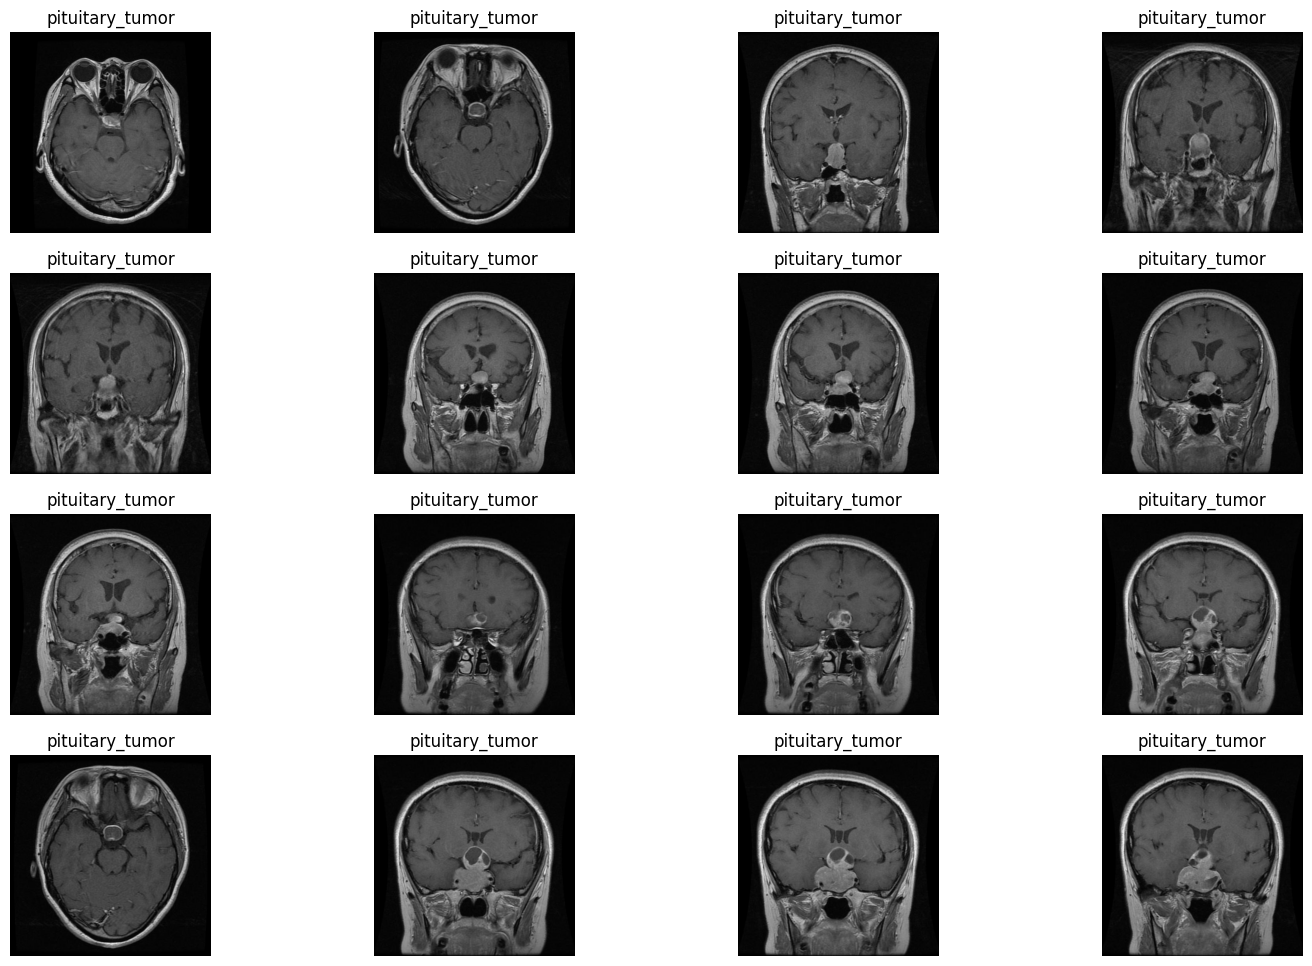

In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model  # Ensure you have this import if you are using it

# Define the directory path
dirct = r'F:\Aman Programming\Brain Tumor Detection\Brain-Tumor-Detection-main'
path = os.path.join(dirct, 'Brain_Tumor_Data', 'Training', 'pituitary_tumor')

# Print the path to verify it
print("Path to pituitary_tumor images:", path)

# Check if the directory exists
if not os.path.exists(path):
    raise FileNotFoundError(f"The directory {path} does not exist")

# List files in the directory
try:
    files = os.listdir(path)
except FileNotFoundError as e:
    print(e)
    files = []

# Verify there are files
if not files:
    raise ValueError("No files found in the specified directory")

# Initialize plot
plt.figure(figsize=(18,12))

# Load your model
# model = load_model('path_to_your_model.h5')  # Replace with the actual path to your model
# Define your labels
dec = {0: 'no_tumor', 1: 'pituitary_tumor'}

# Loop through files and display images
predict_img = []
c = 1
for i in files[:16]:
    plt.subplot(4,4,c)
    
    img_path = os.path.join(path, i)
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: {img_path} could not be read")
        continue
    
    img1 = cv2.resize(img, (224, 224))
    predict_img.append(img1)
    
    # Make predictions
    p = model.predict(np.array(predict_img))
    result = np.argmax(p, axis=1)
    
    plt.title(dec[result[c-1]])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    c += 1

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


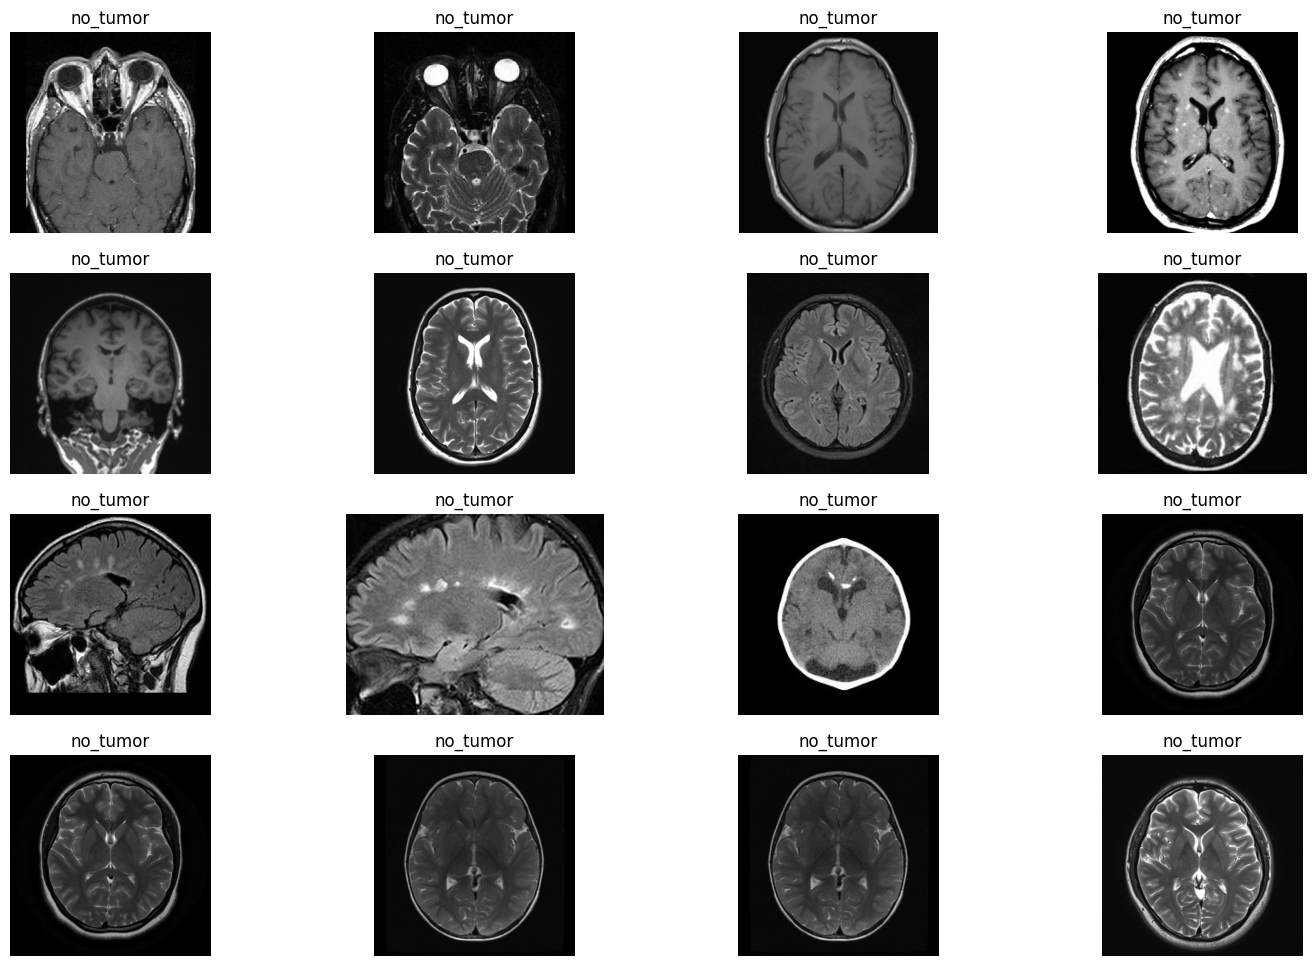

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory path
dir_path = 'F:/Aman Programming/Brain Tumor Detection/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/no_tumor'

# List of image files
image_files = os.listdir(dir_path)

# Initialize plot
plt.figure(figsize=(18,12))

# Predictions and plotting
predict_img = []
c = 1
for img_file in image_files[:16]:
    plt.subplot(4,4,c)
    
    # Construct full image path
    img_path = os.path.join(dir_path, img_file)
    
    # Read the image
    img = cv2.imread(img_path)
    
    # Check if the image is loaded successfully
    if img is None:
        print(f"Warning: {img_path} could not be read")
        continue
    
    # Resize image
    img1 = cv2.resize(img, (224, 224))
    predict_img.append(img1)
    
    # Make predictions (assumes the model is already loaded)
    p = model.predict(np.array(predict_img))
    result = np.argmax(p, axis=1)
    
    # Display the image and prediction
    plt.title(dec[result[c-1]])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')
    c += 1

plt.show()
